In [563]:
# Библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import f_oneway, chi2_contingency

In [564]:
# Подключение файла

from google.colab import files
uploaded = files.upload()

Saving marketing_campaign.csv to marketing_campaign (1).csv


In [733]:
df = pd.read_csv('marketing_campaign.csv')

In [734]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')

In [735]:
# ID для анализа не нужен
df = df.drop('ID', axis=1)

In [736]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,04-09-2012,58,635,88,546,...,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,08-03-2014,38,11,1,6,...,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,21-08-2013,26,426,49,127,...,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,10-02-2014,26,11,4,20,...,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,19-01-2014,94,173,43,118,...,3,6,5,0,0,0,0,0,0,0


In [737]:
# Количество строк
df.shape[0]

2240

In [738]:
# Проверка на дубликаты
df.duplicated().sum()

np.int64(182)

In [739]:
df = df.drop_duplicates()

In [740]:
# Проверим что удалили
df.shape[0]

2058

In [741]:
# Дискретные значения
nunique = df.nunique()
print(nunique[nunique < 12])

Education         5
Marital_Status    8
Kidhome           3
AcceptedCmp3      2
AcceptedCmp4      2
AcceptedCmp5      2
AcceptedCmp1      2
AcceptedCmp2      2
Complain          2
Response          2
dtype: int64


# *Столбцы*

* Year_birth - год рождения

* Education - наличие образования

* Marital_status - семейное положение

* Income - доход

* Kidhome - кол-во детей у клиента

* Dt_customer - с какого момента является клиентом

* Mnt<...> - количество купленных продуктов по категориям

* Num<...>Purchases - количество покупок по способу  

* NumWebVisitsMonth - количество посещений сайта

* AcceptedCmp<...> - участие в маркетинговых компаниях (всего было 5 компаний, значение 1/0 для каждой из компаний)

* Recency - количество дней с последней покупки


# *Типы данных*
1. Категориальные: Marital_status, Education, AcceptedCmp<...> (бинарное значение)
2. Количественный: Year_birth, Income, Recency, Mnt<...>, Num<...>Purchases, Kidhome
3. Дата: Dt_Customer


In [742]:
# Пропуски
miss_val = df.isnull().sum()
print(miss_val[miss_val != 0])

Income    24
dtype: int64


In [757]:
# Заполняем средними значениями Income
df['Income'] = df['Income'].fillna(df['Income'].mean())

In [744]:
# 5-й и 95-й перцентили дохода
income_lower = df['Income'].quantile(0.05)
income_upper = df['Income'].quantile(0.95)

# Убираем выбросы по доходам
df = df[(df['Income'] >= income_lower) & (df['Income'] <= income_upper)]

In [745]:
# Сделаем из даты (Dt_Customer) количественный признак - сколько месяцев клиент в компании

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

latest_date = df['Dt_Customer'].max()
df['Customer_Age_Months'] = (latest_date - df['Dt_Customer']).dt.days // 30

df = df.drop('Dt_Customer', axis=1)

In [746]:
# Категориальные столбцы в численную
df['Education'] = LabelEncoder().fit_transform(df['Education'])
df['Marital_Status'] = LabelEncoder().fit_transform(df['Marital_Status'])

df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_Age_Months
0,1957,2,4,58138.0,0,58,635,88,546,172,...,4,7,0,0,0,0,0,0,1,22
1,1954,2,4,46344.0,1,38,11,1,6,2,...,2,5,0,0,0,0,0,0,0,3
2,1965,2,5,71613.0,0,26,426,49,127,111,...,10,4,0,0,0,0,0,0,0,10
3,1984,2,5,26646.0,1,26,11,4,20,10,...,4,6,0,0,0,0,0,0,0,4
4,1981,4,3,58293.0,1,94,173,43,118,46,...,6,5,0,0,0,0,0,0,0,5


In [747]:
# Вариации признаков

features = df[['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
             'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
             'MntSweetProducts', 'NumDealsPurchases', 'NumWebPurchases',
             'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
             'Customer_Age_Months']]

features_q = df[['Education', 'Marital_Status', 'Income', 'Kidhome',
             'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
             'MntSweetProducts', 'NumDealsPurchases', 'NumWebPurchases',
             'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
             'Customer_Age_Months']]

# features_all = df[['Education', 'Marital_Status', 'Income', 'Kidhome',
#        'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
#        'MntFishProducts', 'MntSweetProducts', 'NumDealsPurchases',
#        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
#        'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
#        'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
#        'Customer_Age_Months']]

features = features_q

In [748]:
# Стандартизируем признаки (0..1)
scaled_features = StandardScaler().fit_transform(features)

<Axes: >

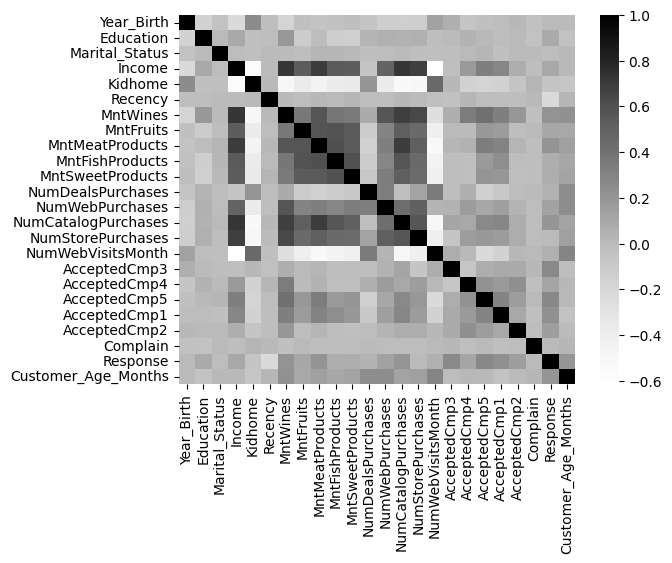

In [749]:
# Построим тепловую карту зависимости признака
corr = df.select_dtypes('number').corr()
sns.heatmap(corr, cmap='Greys')

Видим зависимость количества купленных продуктов (Mnt...) и типов покупок (Num...) от Income

Построим график зависимостей типов продуктов и дохода

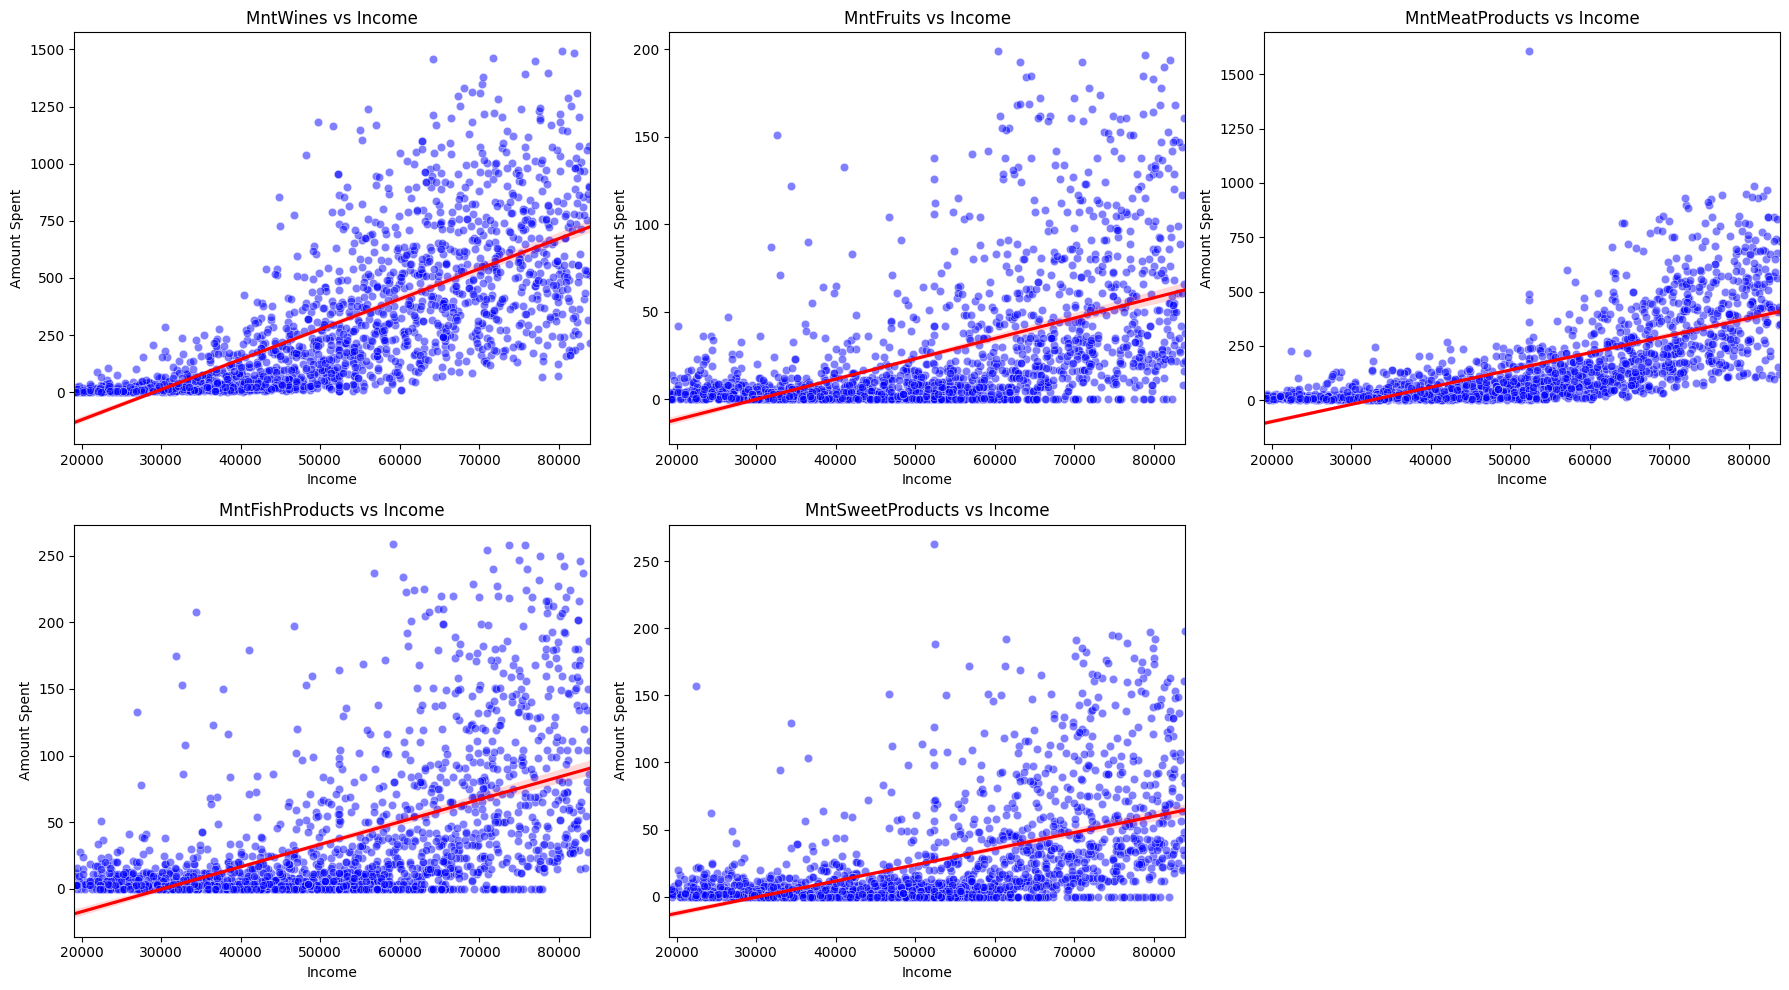

In [750]:

# Список столбцов с тратами
mnt_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']

# Настройка сетки графиков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()


# Определяем min и max Income для оси X
income_min = df['Income'].min()
income_max = df['Income'].max()

for i, col in enumerate(mnt_columns):
    sns.scatterplot(data=df, x='Income', y=col, ax=axes[i], alpha=0.5, color='blue')
    sns.regplot(data=df, x='Income', y=col, ax=axes[i], scatter=False, color='red')  # Линия тренда
    axes[i].set_title(f'{col} vs Income', fontsize=12)
    axes[i].set_xlabel('Income')
    axes[i].set_ylabel('Amount Spent')
    axes[i].set_xlim(income_min, income_max)  # Фиксируем диапазон Income

# Удаление лишнего пустого графика
if len(mnt_columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Видим что у мяса почти что линейная зависимость от дохода. У вина тоже более линейное распределение. Остальные типы еды меньше зависят от дохода.

# *Оптимальное число кластеров*

Text(0, 0.5, 'WCSS')

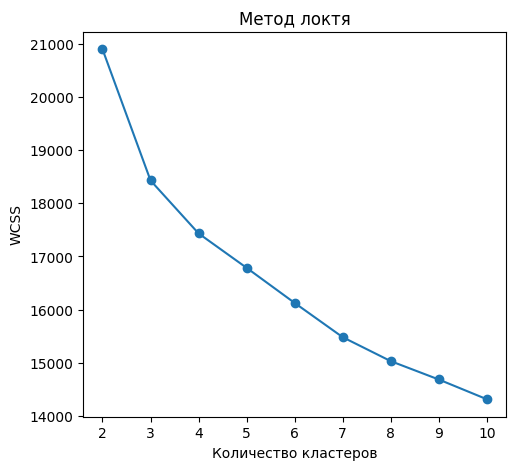

In [751]:
# Оптимальное число кластеров (метод локтей)

wcss = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')

По графику видно, что оптимально взять 4 кластера

# *Построение модели*

In [752]:
# Строим модель
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
df['Cluster'] = clusters

In [753]:
# Уменьшение размерности
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

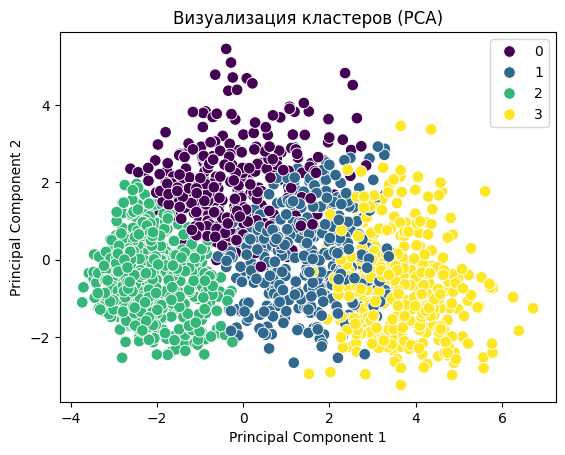

In [754]:
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1],
                hue=clusters, palette='viridis',s=70)

plt.title('Визуализация кластеров (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

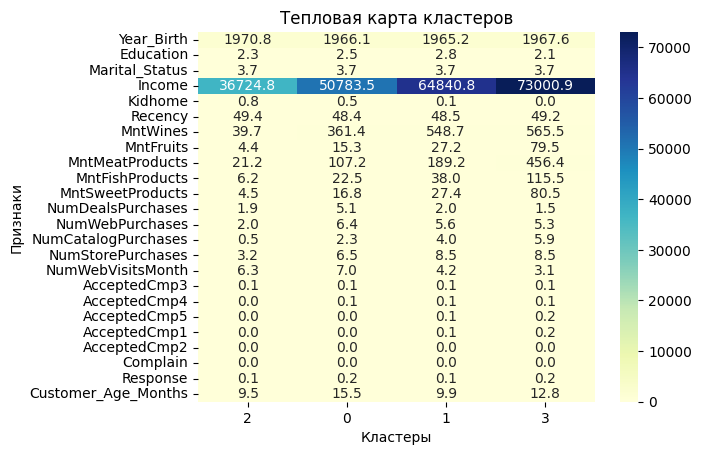

In [755]:
# Группируем данные по кластеры с агрегирующей функцией mean

cluster_profile = df.groupby('Cluster').mean()
cluster_profile_sorted = cluster_profile.sort_values('Income')

sns.heatmap(cluster_profile_sorted.select_dtypes(include=np.number).T,
           cmap='YlGnBu',
           annot=True,
           fmt=".1f")

plt.title('Тепловая карта кластеров')
plt.ylabel('Признаки')
plt.xlabel('Кластеры')
plt.show()

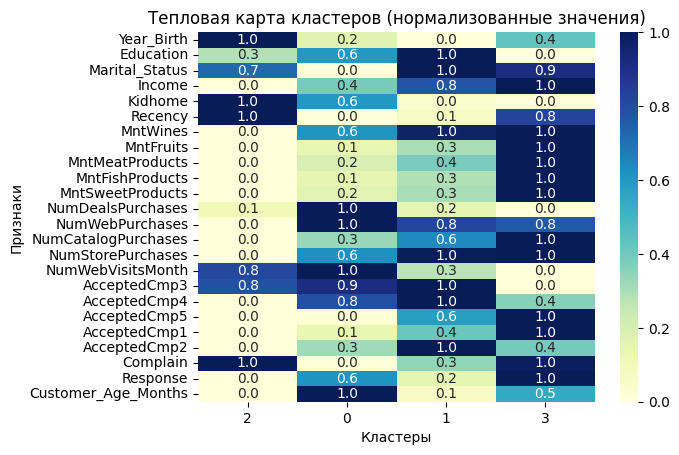

In [756]:
# Можем построить нормализованный (0..1) график


numeric_data = cluster_profile_sorted.select_dtypes(include=np.number)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numeric_data)
normalized_df = pd.DataFrame(normalized_data,
                           columns=numeric_data.columns,
                           index=numeric_data.index)

sns.heatmap(normalized_df.T,
           cmap='YlGnBu',
           annot=True,
           fmt=".1f",
           vmin=0,
           vmax=1)

plt.title('Тепловая карта кластеров (нормализованные значения)')
plt.ylabel('Признаки')
plt.xlabel('Кластеры')
plt.show()

# *Портреты*

Видим 4 портрета кластеров:

0. Наименьший доход (36724), низкое образование, часто есть 1 ребёнок. Мало трат на вино, фрукты, мясо, рыбу, сладости --> то есть вцелом мало покупок. Часто посещает сайт. Почти нет реакции на маркетинговые компании.

3. Доход низкий (50783), Среднее (по датасету) образование, в половине случаев есть 1 ребёнок. Средне трат на вино, фрукты, мясо, рыбу, сладости --> трат больше, чем у 0 категории. Часто посещает сайт, больше всего делает покупок через магазин.

2. Доход средний (64840), высокое образование, дети очень редко. Высокие траты на все категории продуктов. Часто покупают через каталоги и в магазине. Больше вовлечённости в маркетиновые компании.

1. Доход высокий (73000), образование низкое (забавно...), детей нет почти что, траты на все категории высокие. В основном покупки через каталоги и магазины. Больше всех реакции на маркетинговые компании.

# *Рекомендации*

Видим сильную зависимость количества купленных продуктов от степени заработка.

Возможные выводы (рекомендации для компании):

1. Акцентировать маркетинговые компании на людях с высоким доходом
2. Адаптировать каталоги под клиентов со средним и высоким доходом, а сайт -- под клиентов с низким
3. Продажа детского питания должна быть адаптирована для клиентов с низким и наименьшими доходами.